# Packages

In [43]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from scipy import signal
from osgeo import gdal

# Functions and constants

In [44]:
def get_powerlaw_constants(x,y):
    polyfit = np.polyfit(np.log10(x),np.log10(y),1)
    l,n = 10**polyfit[1],polyfit[0]
    return l,n

def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray())
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

In [45]:
def get_autocorrelation(x,y,z,edgewidth):
    pad  = np.pad(np.ones((np.shape(z)[0]-2*edgewidth,np.shape(z)[1]-2*edgewidth)),
                  (edgewidth,edgewidth),
                  mode='constant',constant_values=0)
    zn   = (z-np.mean(z))/np.std(z)
    zfft = np.fft.fft2(zn)
    zc   = np.fft.fftshift(np.fft.ifft2((zfft*pad)*np.conj((zfft*pad)))).real
    zc  /= np.max(zc)
    xc   = x-np.mean(x)
    yc   = y-np.mean(y)
    return xc,yc,zc

def get_angle_spacing(xc,yc,zc):
    idx_min = np.argwhere(zc==np.min(zc))[0]
    x_min = xc[idx_min[1]]
    y_min = yc[idx_min[0]]
    angle   = np.arctan2(y_min,x_min)
    spacing = ((x_min*2)**2+(y_min*2)**2)**0.5
    return angle,spacing


In [46]:
s_to_yrs = 1/(60*60*24*365)

# Read data

In [47]:
data = xr.open_dataset('2017-2021.nc')
data

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 2, latitude: 2, time: 43824)
Coordinates:
  * longitude  (longitude) float32 8B 131.4 131.6
  * latitude   (latitude) float32 8B -20.15 -20.25
  * time       (time) datetime64[ns] 351kB 2017-01-01 ... 2021-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 701kB ...
    v10        (time, latitude, longitude) float32 701kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-29 15:00:08 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [48]:
latind,lonind = 0,0

time = np.asarray(data.time)
u10  = np.asarray(data.u10[:,latind,lonind])
v10  = np.asarray(data.v10[:,latind,lonind])

In [49]:
data_geotiff = gdal.Open('output_AW3D30.tif')
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(data_geotiff)

# Analysis

In [50]:
U10 = (u10**2+v10**2)**0.5

In [51]:
np.diff(np.arange(10))[0]

1

In [52]:
np.diff(np.arange(10)*2)

array([2, 2, 2, 2, 2, 2, 2, 2, 2])

In [53]:
s_to_yrs

3.1709791983764586e-08

In [54]:
time_seconds = (time-np.min(time))/np.timedelta64(1,'s')
f, PUU = signal.welch(U10,1/np.diff(time_seconds)[0],nperseg=len(time),scaling='spectrum')
f_smooth, PUU_smooth = signal.welch(U10,1/np.diff(time_seconds)[0],
                                    nperseg=int(1/s_to_yrs/np.diff(time_seconds)[0]/12),
                                    scaling='spectrum')

In [55]:
power_peak_timescale_seconds = 1/f[np.argmax(PUU)]
power_peak_timescale_days = power_peak_timescale_seconds/60/60/24
power_peak_timescale_days

1.0

In [56]:
edgewidth = 2
lonc,latc,zc = get_autocorrelation(lon_geotiff,lat_geotiff,z_geotiff,edgewidth)
duneangle,dunespacing = get_angle_spacing(lonc,latc,zc)

# Plots

Text(0, 0.5, 'wind speed (m/s)')

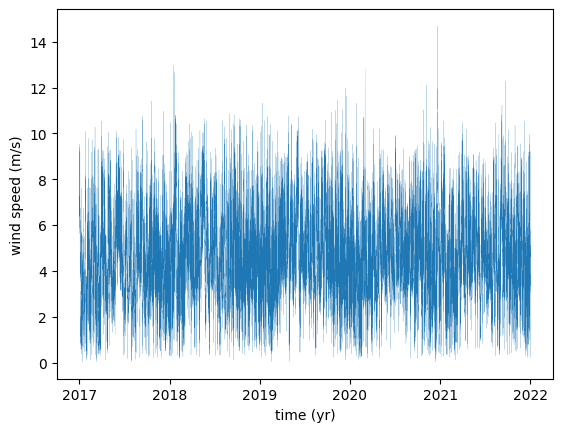

In [57]:
plt.plot(time,U10,lw=0.1)
plt.xlabel('time (yr)')
plt.ylabel('wind speed (m/s)')

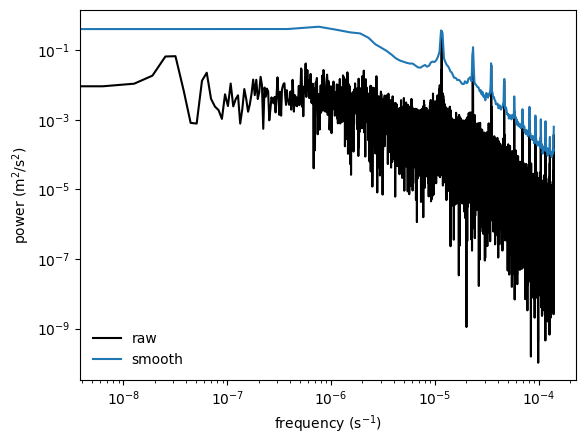

In [64]:
plt.plot(f, PUU,'k',label='raw')
plt.plot(f_smooth, PUU_smooth,label='smooth')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency (s$^{-1}$)')
plt.ylabel('power (m$^2$/s$^2$)')
plt.legend(loc=0,frameon=False)

/var/folders/cw/shth1g7j0nd3fdk_jzpdq4gdll63_0/T/ipykernel_83030/3256515263.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(s_to_yrs/f, PUU)
/var/folders/cw/shth1g7j0nd3fdk_jzpdq4gdll63_0/T/ipykernel_83030/3256515263.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(s_to_yrs/f_smooth, PUU_smooth)


Text(0, 0.5, 'power (m$^2$/s$^2$)')

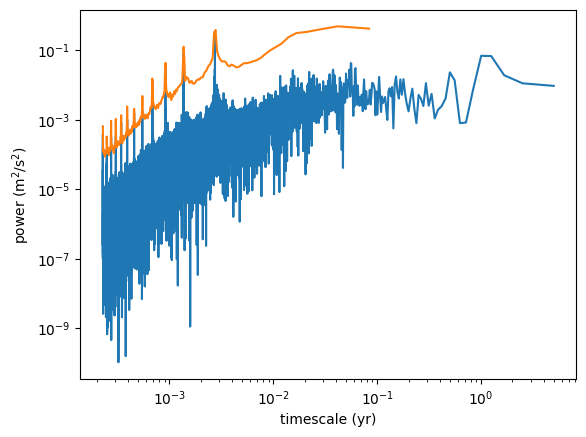

In [16]:
plt.plot(s_to_yrs/f, PUU)
plt.plot(s_to_yrs/f_smooth, PUU_smooth)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('timescale (yr)')
plt.ylabel('power (m$^2$/s$^2$)')

In [10]:
1/365

0.0027397260273972603

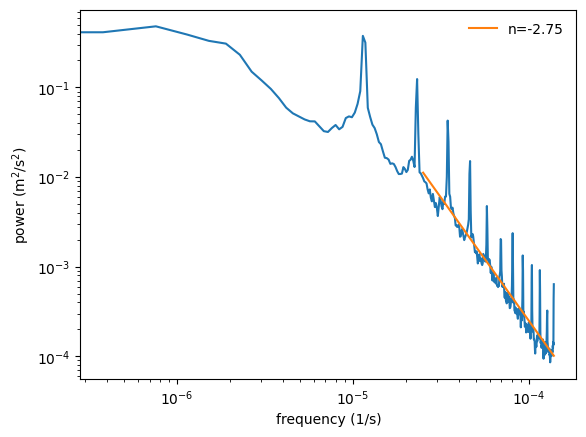

In [17]:
f_minbound = 2.5e-5

l_smooth,n_smooth = get_powerlaw_constants(f_smooth[f_smooth>f_minbound], PUU_smooth[f_smooth>f_minbound])
plt.plot(f_smooth, PUU_smooth)
plt.plot(f_smooth[f_smooth>f_minbound],l_smooth*f_smooth[f_smooth>f_minbound]**n_smooth,label='n=%.2f'%n_smooth)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency (1/s)')
plt.ylabel('power (m$^2$/s$^2$)')
plt.legend(frameon=False)

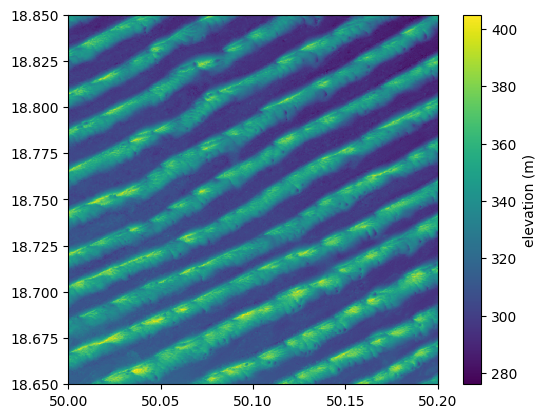

In [35]:
plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff)
plt.axis('square')
plt.colorbar(label='elevation (m)')

(-0.1001390820584298,
 0.1001390820584298,
 -0.10013908205842625,
 0.10013908205843336)

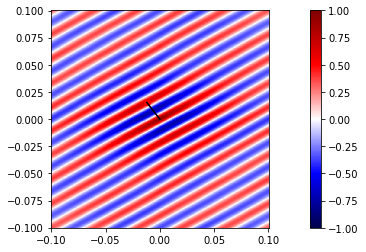

In [99]:
plt.pcolormesh(lonc,latc,zc,vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()
plt.plot([0,dunespacing*np.cos(duneangle)],[0,dunespacing*np.sin(duneangle)],c='k')
plt.scatter(dunespacing*np.cos(duneangle),dunespacing*np.sin(duneangle),c='r')
plt.axis('square')

Text(0, 0.5, 'latitude ($^\\circ$)')

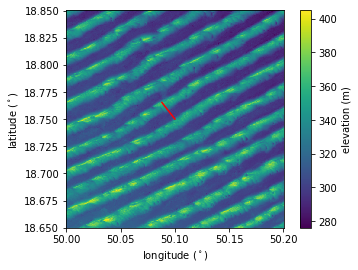

In [100]:
plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff)
plt.plot([np.mean(lon_geotiff),np.mean(lon_geotiff)+dunespacing*np.cos(duneangle)],
         [np.mean(lat_geotiff),np.mean(lat_geotiff)+dunespacing*np.sin(duneangle)],c='r')
plt.axis('square')
plt.colorbar(label='elevation (m)')
plt.xlabel('longitude ($^\\circ$)')
plt.ylabel('latitude ($^\\circ$)')